In [196]:
%matplotlib inline

import yfinance as yf
import bt
import matplotlib.pyplot as plt

In [197]:
# Fund managers report their holdings every month. 
# They don’t want to tell investors they lost money the latest meme stock. So they sell their meme stocks and buy higher quality assets, like bonds.
# We might be able to take advantage of this effect by buying bonds toward the end of the month and selling them at the beginning.

data = yf.download("TLT", start="2010-01-01", end="2022-12-31")
data = data.rename(columns = {'Adj Close':'TLT'})
data = data.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)

[*********************100%***********************]  1 of 1 completed


In [198]:
def build_strategy(weights):
    return bt.Strategy(
        'wd', 
        [bt.algos.SelectAll(), 
         bt.algos.WeighTarget(weights), 
         bt.algos.Rebalance()]
    )


In [199]:
def build_backtest(strategy, df, initial_capital, commission_model):
    return bt.Backtest(
        strategy,
        df,
        initial_capital=initial_capital,
        commissions=commission_model,
        integer_positions=False
    )

In [200]:
def commission_model(q, p):

    # p is price, q is quantity
    val = abs(q * p)
    if val > 2000:
        return 8.6
    if val > 1000:
        return 4.3
    if val > 100:
        return 1.5
    return 1.0

In [201]:
def add_dom(df):
    
    # add the day of month and return
    added = df.copy()
    added["day_of_month"] = df.index.day
    return added

In [202]:
def add_weights(df, symbol):
    
    # start with no position within the month
    strategy = df[[symbol]].copy()
    
    # start with no position within the month
    strategy.loc[:] = 0
    
    # short within the first week of the month
    strategy.loc[df.day_of_month <= 7] = -1

    # long during the last week of the month
    strategy.loc[df.day_of_month >= 23] = 1
    
    return strategy

In [203]:
initial_capital = 10000

# RUN BACKTEST

In [204]:
# add the day of month
data_with_dom = add_dom(data)

# get the portfolio weights
weights = add_weights(data_with_dom, 'TLT')

# build the bt strategy
strategy = build_strategy(weights)

#build the backtest
backtest = build_backtest(strategy, data, initial_capital, commission_model)

#run the backtest
first_res = bt.run(backtest)

In [205]:
first_res.display()

Stat                 wd
-------------------  ----------
Start                2009-12-30
End                  2022-12-30
Risk-free rate       0.00%

Total Return         99.31%
Daily Sharpe         0.55
Daily Sortino        0.87
CAGR                 5.45%
Max Drawdown         -19.61%
Calmar Ratio         0.28

MTD                  -2.83%
3m                   10.04%
6m                   13.68%
YTD                  29.22%
1Y                   29.47%
3Y (ann.)            13.63%
5Y (ann.)            10.03%
10Y (ann.)           5.18%
Since Incep. (ann.)  5.45%

Daily Sharpe         0.55
Daily Sortino        0.87
Daily Mean (ann.)    5.88%
Daily Vol (ann.)     10.70%
Daily Skew           0.04
Daily Kurt           5.82
Best Day             3.97%
Worst Day            -5.24%

Monthly Sharpe       0.58
Monthly Sortino      1.04
Monthly Mean (ann.)  5.82%
Monthly Vol (ann.)   10.00%
Monthly Skew         -0.16
Monthly Kurt         3.00
Best Month           11.17%
Worst Month          -11.97%

Yearl

<AxesSubplot:title={'center':'Equity Progression'}>

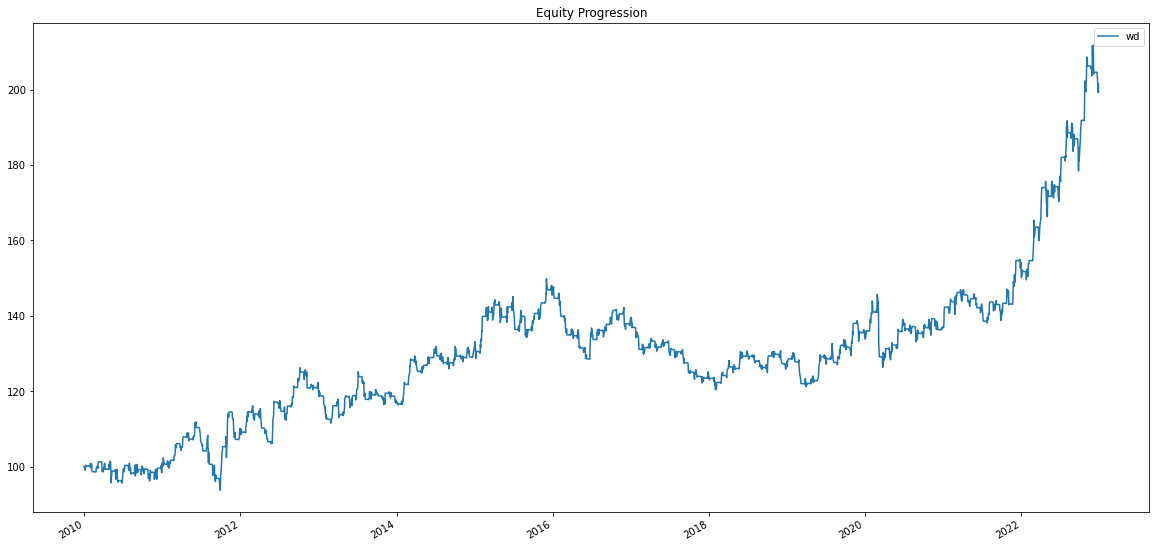

In [206]:
first_res.plot(figsize=(20, 10))

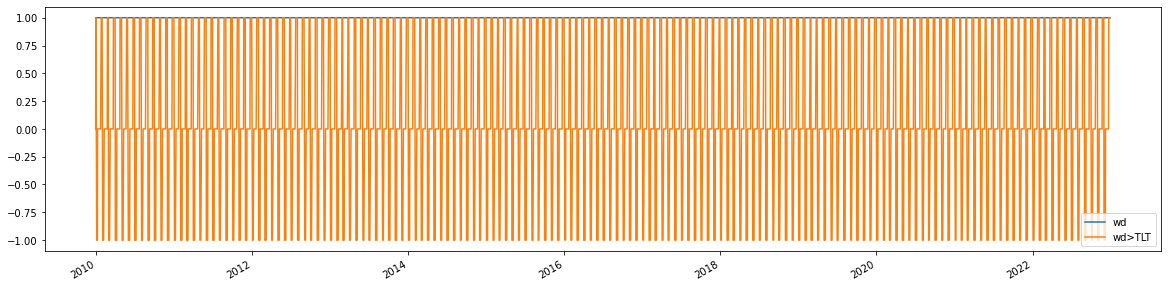

In [207]:
first_res.plot_weights('wd', figsize=(20, 5))